In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [7]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [58]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity 
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:]['Date'].values
        count = 0
        total = len(date_test)
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
#             print('---')
            count += 1
            print(round(count/total*100, 2))
        print('---')

        date_train = self.df[:train_size]['Date'].values[1:]
        d = best_params['diff_order']
        y_train = self.prepare_data(d, train_size)['y'].values
        
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
          'y_train_predict': y_train_predict['yhat'].values
        }
        
        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        diff = best_params['diff_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))
        
        train_size = len(self.df[ self.df['Date'] <= train_datetime])
        df_train = self.prepare_data(diff, train_size)
        
        model = Prophet()
        fit_model = model.fit(df_train)
        
        if self.periodicity == '1_day':
            future = model.make_future_dataframe(periods=1, freq='D')
        if self.periodicity == '1_hour':
            future = model.make_future_dataframe(periods=1, freq='H')
            
        forecast = model.predict(future)
        pred = forecast.iloc[-1]['yhat']
        
#         print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
#         pred = fit_model.predict(start = current_datetime, end = current_datetime)
#         print('train_size ->', train_size)    
#         print('train_datetime ->', train_datetime)
#         print('self.df[:train_size] ->', self.df[:train_size]['Date'].values[-1])
        
        #integration
        if diff == 1:
            
            last_close_price = self.df[:train_size]['Close'].values[-1]
            pred = last_close_price + pred
            
        if diff == 2:
            
            last_close_price = self.df[:train_size]['Close'].values[-1]
            before_last_close_price = self.df[:train_size]['Close'].values[-2]
            last_close_diff_price = last_close_price - before_last_close_price
            pred = last_close_price + last_close_diff_price + pred
        
        return pred
    
    def prepare_data(self, diff, train_size):

        if diff == 0:
            data = {
                'ds': self.df[:train_size]['Date'].values,
                'y': self.df[:train_size]['Close'].values
            }

        if diff == 1:
            data = {
                'ds': self.df[:train_size]['Date'].values[1:],
                'y': self.df[:train_size]['Close'].diff().values[1:]
            }

        if diff == 2:
            data = {
                'ds': self.df[:train_size]['Date'].values[2:],
                'y': self.df[:train_size]['Close'].diff().diff().values[2:]
            }

        df_result = pd.DataFrame(data)
        
        return df_result
    
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        best_mse = np.inf 
        best_params = None
        best_fit = None

        diff_range = range(3)
        d_range = range(3) # [0,1,2]

        for d in d_range:
            
            n_diff = 0
            X = self.df[:train_size]['Close'].values
            
            while n_diff < d:
                X = np.diff(X)
                n_diff +=1
            
            result = adfuller(X[d:]) #[d:] exclude the first d nan values
            p_value = result[1]
            
            if p_value < 0.05:
                print('stationary d:', d)
                #stationary
                break
            
        df_train = self.prepare_data(d, train_size)

        try:
            model = Prophet()
            fit_model = model.fit(df_train)

            df_aux = fit_model.predict()
            mse = round(mean_squared_error(df_train['y'], df_aux['yhat']), 4)

            if mse < best_mse:

                best_mse = mse
                best_params = {'diff_order': d}
                best_fit = fit_model

        except:
            pass

        print('MSE', best_mse, 'best_params', best_params)
        
        y_train_predict = fit_model.predict()
        
        return best_params, train_size, y_train_predict

In [56]:
#variar os seguintes parametros:
#growth
#changepoints
#n_changepoints
#changepoint_prior_scale

In [76]:
### MAIN

# df = df_gemini_price_d.copy()
df = df_gemini_price_1h.copy()

df = df.sort_values(by = ['Date']).reset_index(drop = True)
df = df.loc[:, ['Date', 'Close']]

prophet_forecast = ProphetForecast(df = df,
                         percentage_train_size = 0.80,
                         periodicity = '1_hour'
                        )
df_train, df_test = prophet_forecast.perform()

stationary d: 1
MSE 4436.8178 best_params {'diff_order': 1}
0.01
0.03
0.04
0.05
0.06
0.08
0.09
0.1
0.11
0.13
0.14
0.15
0.16
0.18
0.19
0.2
0.22
0.23
0.24
0.25
0.27
0.28
0.29
0.3
0.32
0.33
0.34
0.35
0.37
0.38
0.39
0.41
0.42
0.43
0.44
0.46
0.47
0.48
0.49
0.51
0.52
0.53
0.54
0.56
0.57
0.58
0.6
0.61
0.62
0.63
0.65
0.66
0.67
0.68
0.7
0.71
0.72
0.73
0.75
0.76
0.77
0.79
0.8
0.81
0.82
0.84
0.85
0.86
0.87
0.89
0.9
0.91
0.92
0.94
0.95
0.96
0.98
0.99
1.0
1.01
1.03
1.04
1.05
1.06
1.08
1.09
1.1
1.11
1.13
1.14
1.15
1.17
1.18
1.19
1.2
1.22
1.23
1.24
1.25
1.27
1.28
1.29
1.3
1.32
1.33
1.34
1.36
1.37
1.38
1.39
1.41
1.42
1.43
1.44
1.46
1.47
1.48
1.49
1.51
1.52
1.53
1.55
1.56
1.57
1.58
1.6
1.61
1.62
1.63
1.65
1.66
1.67
1.68
1.7
1.71
1.72
1.74
1.75
1.76
1.77
1.79
1.8
1.81
1.82
1.84
1.85
1.86
1.87
1.89
1.9
1.91
1.93
1.94
1.95
1.96
1.98
1.99
2.0
2.01
2.03
2.04
2.05
2.06
2.08
2.09
2.1
2.12
2.13
2.14
2.15
2.17
2.18
2.19
2.2
2.22
2.23
2.24
2.25
2.27
2.28
2.29
2.31
2.32
2.33
2.34
2.36
2.37
2.38
2.39
2.41
2.42
2.4

In [75]:
# Prophet 1d feito
# MSE 82912.1164 best_params {'diff_order': 1}
# mae 262.6084 mape 3.0444 mse 164076.7963 rmse 405.0639 rmspe 5.3367 r2 0.9284 pearson 0.9645

In [1]:
# Prophet 1h
# MSE 4436.8313 best_params {'diff_order': 1}
# mae 44.0078 mape 0.5062 mse 6895.6031 rmse 83.0398 rmspe 1.0089 r2 0.997 pearson 0.9985

<AxesSubplot:xlabel='date_train'>

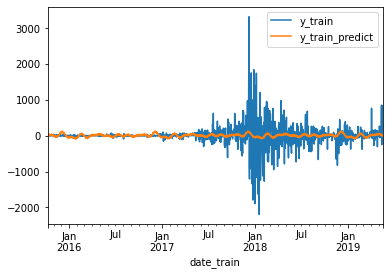

In [69]:


df_train.plot(x='date_train', y=['y_train', 'y_train_predict'], kind='line')

In [78]:
# df_train.tail()
# df_test.head()

# df_train.to_csv('train_prophet_1d.csv', sep = "\t", index = False)
# df_test.to_csv('test_prophet_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_prophet_1d.csv', sep = "\t")
# pd.read_csv('test_prophet_1d.csv', sep = "\t")

df_train.to_csv('train_prophet_1h.csv', sep = "\t", index = False)
df_test.to_csv('test_prophet_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_prophet_1h.csv', sep = "\t")
# pd.read_csv('test_prophet_1h.csv', sep = "\t")

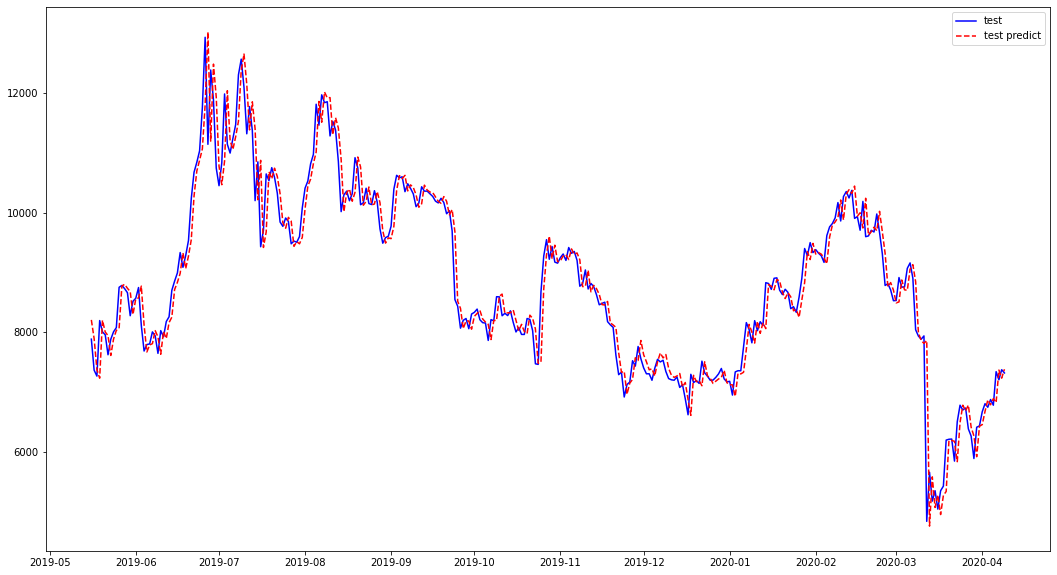

In [70]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()